# Price Returns Forecasting with Hidden Markov
  
This notebook explores the predictability of daily price returns using the hidden states derived from Hidden Markov models.  

An optimal number of 10 hidden states was used and the model was trained on data during the training period 1993-2009 while the sample set of `possible_outcomes` is derived from the validation period between 2010-2017 to avoid data leakage. Finally, the trained model tests its predictions, making use of the set of `possible_outcomes` in the testing period between 2018-2023/1.  

Both failed to perform profitably in the actual backtest.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyfolio as pyf

from hmmlearn.hmm import GaussianHMM

import itertools

from tqdm import tqdm

%config NotebookApp.iopub_data_rate_limit=10000000    # need to increase speed limit for model.score(total_data)

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# Enter ticker symbol here
ticker = 'SPY'


# Read historical price data for ticker
filepath = f'./datasets/{ticker}.csv'
asset = pd.read_csv(filepath)
asset['Date'] = pd.to_datetime(asset['Date'])
asset.set_index('Date', inplace=True)

In [3]:
# Resample time series into weekly Friday series
# weeklies = asset.resample('W-FRI').last()
# weeklies

In [4]:
# Split dataset into train+val+test sets

# Find the index position to split on first
train_index = np.where(asset.index > '2009-12-31')[0][0]   
val_index = np.where(asset.index > '2017-12-31')[0][0] 
print(train_index, val_index)

# Split data
train_data = asset.iloc[0:train_index]
val_data = asset.iloc[train_index+1:val_index]
test_data = asset.iloc[val_index:]


4264 6277


In [5]:
test_data

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME
Date,,,,,,
2018-01-02,267.839996,268.809998,267.399994,268.769989,246.766617,86655700
2018-01-03,268.959991,270.640015,268.959991,270.470001,248.327469,90070400
2018-01-04,271.200012,272.160004,270.540009,271.609985,249.374069,80636400
2018-01-05,272.510010,273.559998,271.950012,273.420013,251.035965,83524000
2018-01-08,273.309998,274.100006,272.980011,273.920013,251.495087,57319200
...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300


In [6]:
def augment_features(dataframe):
    """
    Creates new features that indicates the relative differences between High/Low/Close prices with the Open price
    """
    fracocp = (dataframe['CLOSE']-dataframe['OPEN'])/dataframe['OPEN']
    frachp = (dataframe['HIGH']-dataframe['OPEN'])/dataframe['OPEN']
    fraclp = (dataframe['OPEN']-dataframe['LOW'])/dataframe['OPEN']
    new_dataframe = pd.DataFrame({'delOpenClose':fracocp,
                                  'delHighOpen':frachp,
                                  'delLowOpen':fraclp})
    new_dataframe.set_index(dataframe.index)
    return new_dataframe



def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))


In [7]:
model = GaussianHMM(n_components=10)

feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)

model.fit(features_train)

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


GaussianHMM(n_components=10)

## Generating the sample space of Possible Outcomes
We will now use the validation set to derive our sample space of possible outcomes. These are outcomes that have been realized during the period 2010-2017 inclusive. For each feature, we will simply use Cartesian product to get a set of all possible permutations of values from the three augmented features.  

To avoid adding more model complexity, we assume that 1) the distribution of each augmented feature is across an evenly-spaced interval instead of being fully continuous. 2) We assume possible values for the start and end of the intervals. 

In [8]:
# Generating possible outcomes based on the val set
val_augmented = augment_features(val_data)
fracocp = val_augmented['delOpenClose']
frachp = val_augmented['delHighOpen']
fraclp = val_augmented['delLowOpen']

sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 20)   # the more bins you separate here, the more accurate is your final preds, but running at 50 will result in extremely slow perf!
sample_space_fraclp = np.linspace(fraclp.min(), fraclp.max(), 20)
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 20)

possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

In [9]:
len(possible_outcomes)   # There are 8000 possible outcomes based on what we experienced in the validation period

8000

## Prediction Methodology
At the end of every Friday's trading session, we are predicting next Friday's weekly returns.  

We will use the last four periods of weekly returns (inclusive of today's returns) to predict next Friday's returns. This is specified as the hyperparameter `num_latent_periods`. Next, we will add a possible outcome from the set of `possible_outcomes` created earlier to the last row and compute the log-probability of this 5-step sequence using our trained model. Since we have 8000 "possible outcomes", there will be 8000 different values of log-probability (one for each sequence). Finally, the sequence with the maximum log-probability is selected as the most likely sequence to happen and the outcome is recorded as the next `predicted_close_price`.  

Specify the number of timesteps to predict for using the hyperparameter `num_periods_to_predict`. Since there are 265 weeks between 2018-2023/1, we will create 265 `predicted_close_prices`.

In [11]:
test_data.shape[0]

1277

In [12]:
# Checking predictions

num_latent_periods = 4
num_periods_to_predict = test_data.shape[0]

In [13]:
predicted_close_prices = []

for i in tqdm(range(num_periods_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_periods)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))
    
    outcome_scores = []
    for outcome in possible_outcomes:     # each outcome is 1x3 array
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))   # huge bottleneck here if got too many outcomes to score on
        
    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]   # returns idx of the max value
    predicted_close_prices.append(test_data.iloc[i]['OPEN'] * (1 + most_probable_outcome[0]))  # add the day's Open with the fracocp

100%|██████████| 1277/1277 [47:06<00:00,  2.21s/it]


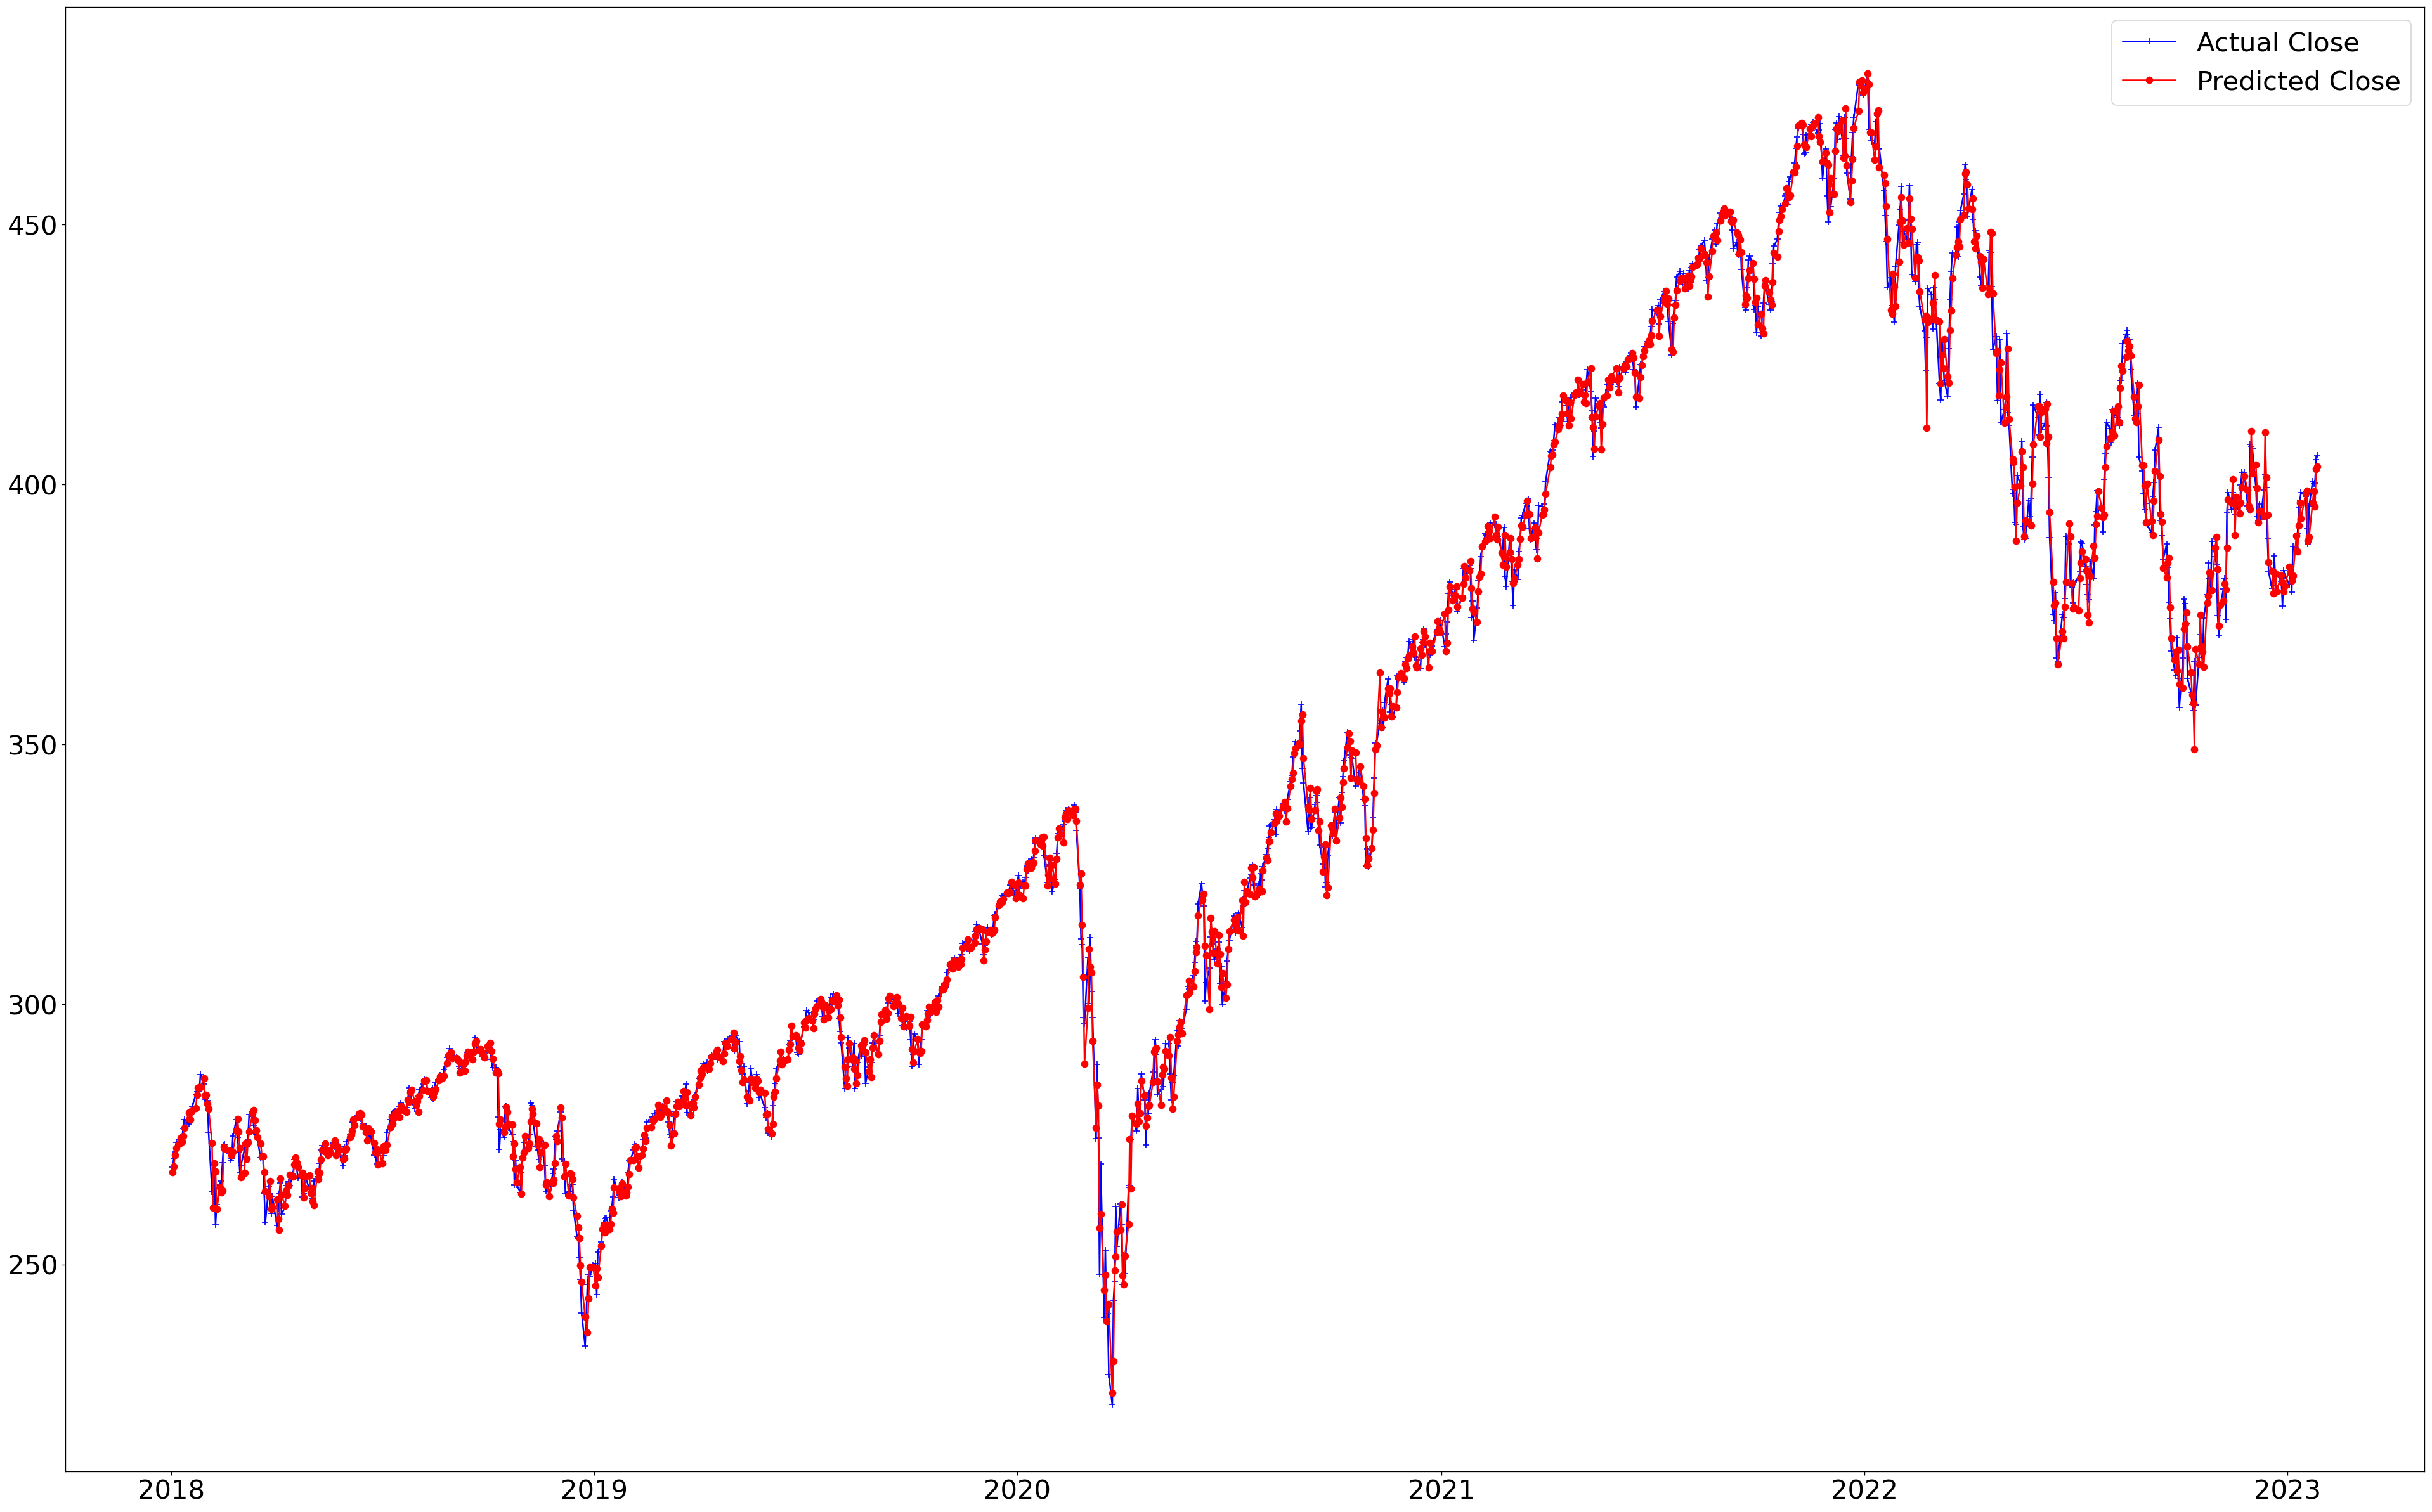

In [14]:
# Visualize Predicted Close prices against the Actual Close
plt.figure(figsize=(40,25), dpi=120)

x_axis = np.array(test_data.index[0:num_periods_to_predict], dtype='datetime64[ms]')
plt.plot(x_axis, test_data.iloc[0:num_periods_to_predict]['CLOSE'], 'b+-', label='Actual Close')
plt.plot(x_axis, predicted_close_prices, 'ro-', label='Predicted Close')
plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25);


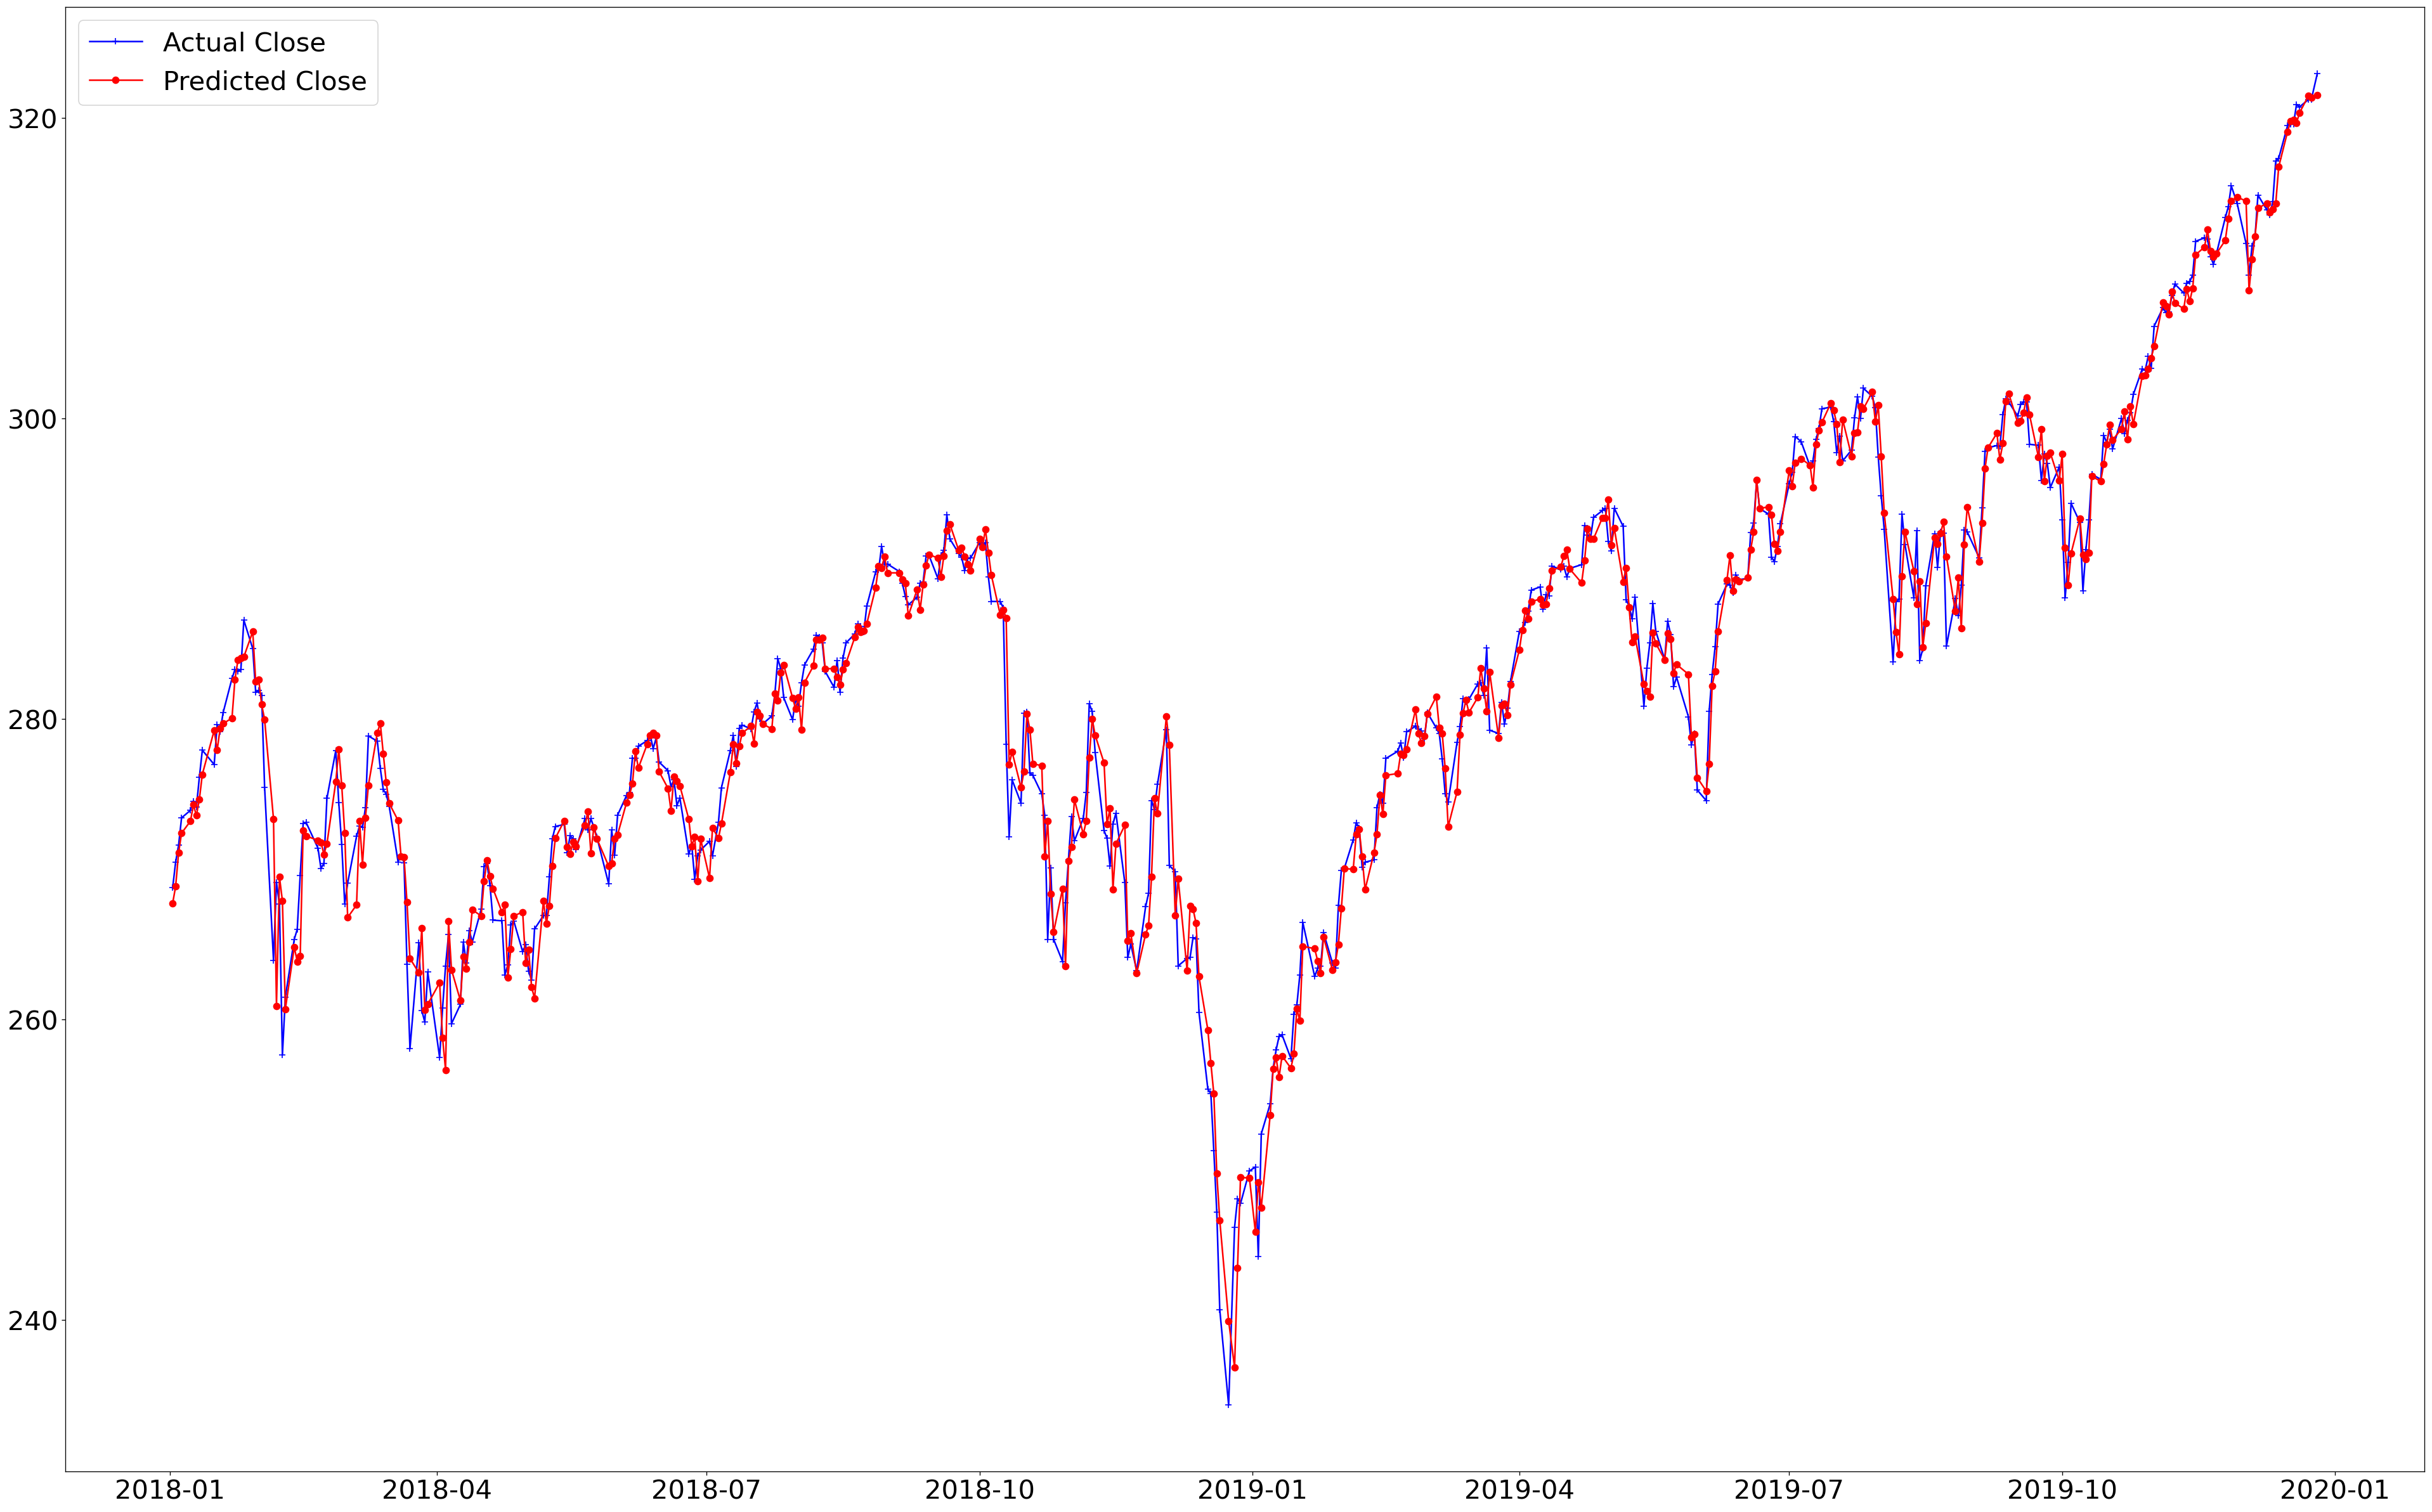

In [15]:
# Zoom in to just 2018-2019
plt.figure(figsize=(40,25), dpi=120)

x_axis = np.array(test_data.index[0:500], dtype='datetime64[ms]')
plt.plot(x_axis, test_data.iloc[0:500]['CLOSE'], 'b+-', label='Actual Close')
plt.plot(x_axis, predicted_close_prices[0:500], 'ro-', label='Predicted Close')
plt.legend(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25);

# The predicted close prices were mostly off-the-mark and do not match actual close!

In [16]:
len(predicted_close_prices)

1277

In [17]:
def get_signal(test_data, preds, num_days_to_predict):
    """
    Converts the predicted close prices into binary signals.
    
    Where if 1-week returns < 0.0, regime=1 (bear market); else regime=0 (bull market)
    """
    df = test_data[:num_days_to_predict].copy()
    df['CLOSE_PRED'] = preds
    df['1W_RETURNS_PRED'] = df['CLOSE_PRED'].pct_change()
    df.dropna(subset=['1W_RETURNS_PRED'], inplace=True)
    df['regime'] = np.where(df['1W_RETURNS_PRED'] <0, 1.0, 0.0)
    return df   
    

In [18]:
test_signals = get_signal(test_data, predicted_close_prices, num_periods_to_predict)

# In this case, no shifting needed since signals and trading are for the same day
test_signals

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,CLOSE_PRED,1W_RETURNS_PRED,regime
Date,,,,,,,,,
2018-01-03,268.959991,270.640015,268.959991,270.470001,248.327469,90070400,268.853322,0.004182,0.0
2018-01-04,271.200012,272.160004,270.540009,271.609985,249.374069,80636400,271.092455,0.008328,0.0
2018-01-05,272.510010,273.559998,271.950012,273.420013,251.035965,83524000,272.401933,0.004830,0.0
2018-01-08,273.309998,274.100006,272.980011,273.920013,251.495087,57319200,273.201603,0.002936,0.0
2018-01-09,274.399994,275.250000,274.079987,274.540009,252.064240,57254000,274.291167,0.003988,0.0
...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800,396.562663,0.016970,0.0
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900,398.721810,0.005445,0.0
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300,395.792979,-0.007346,1.0


In [19]:
# Calculate cumulative returns
test_signals['daily_profit'] = np.where(test_signals['regime']==1, test_signals['OPEN']-test_signals['CLOSE'], test_signals['CLOSE']-test_signals['OPEN'])
test_signals['daily_backtested_returns'] = test_signals['daily_profit'] / test_signals['OPEN']
test_signals['cum_returns'] = (1+test_signals['daily_backtested_returns']).cumprod()-1
test_signals

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,CLOSE_PRED,1W_RETURNS_PRED,regime,daily_profit,daily_backtested_returns,cum_returns
Date,,,,,,,,,,,,
2018-01-03,268.959991,270.640015,268.959991,270.470001,248.327469,90070400,268.853322,0.004182,0.0,1.510010,0.005614,0.005614
2018-01-04,271.200012,272.160004,270.540009,271.609985,249.374069,80636400,271.092455,0.008328,0.0,0.409973,0.001512,0.007134
2018-01-05,272.510010,273.559998,271.950012,273.420013,251.035965,83524000,272.401933,0.004830,0.0,0.910004,0.003339,0.010498
2018-01-08,273.309998,274.100006,272.980011,273.920013,251.495087,57319200,273.201603,0.002936,0.0,0.610016,0.002232,0.012753
2018-01-09,274.399994,275.250000,274.079987,274.540009,252.064240,57254000,274.291167,0.003988,0.0,0.140015,0.000510,0.013270
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800,396.562663,0.016970,0.0,3.910004,0.009856,0.037787
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900,398.721810,0.005445,0.0,1.320007,0.003309,0.041221
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300,395.792979,-0.007346,1.0,-4.399994,-0.011112,0.029650


In [20]:
# Export test signals for backtesting
test_signals.to_csv('regime_filter.csv', index=True)

## Backtesting Profitability for Test Period 2018-2023/1

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2018-01-03
End date,2023-01-27
Total months,60
,Backtest
Annual return,0.8%
Cumulative returns,3.9%
Annual volatility,15.5%
Sharpe ratio,0.13
Calmar ratio,0.02
Stability,0.26
Max drawdown,-32.0%


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=returns.index)
C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=returns.index)


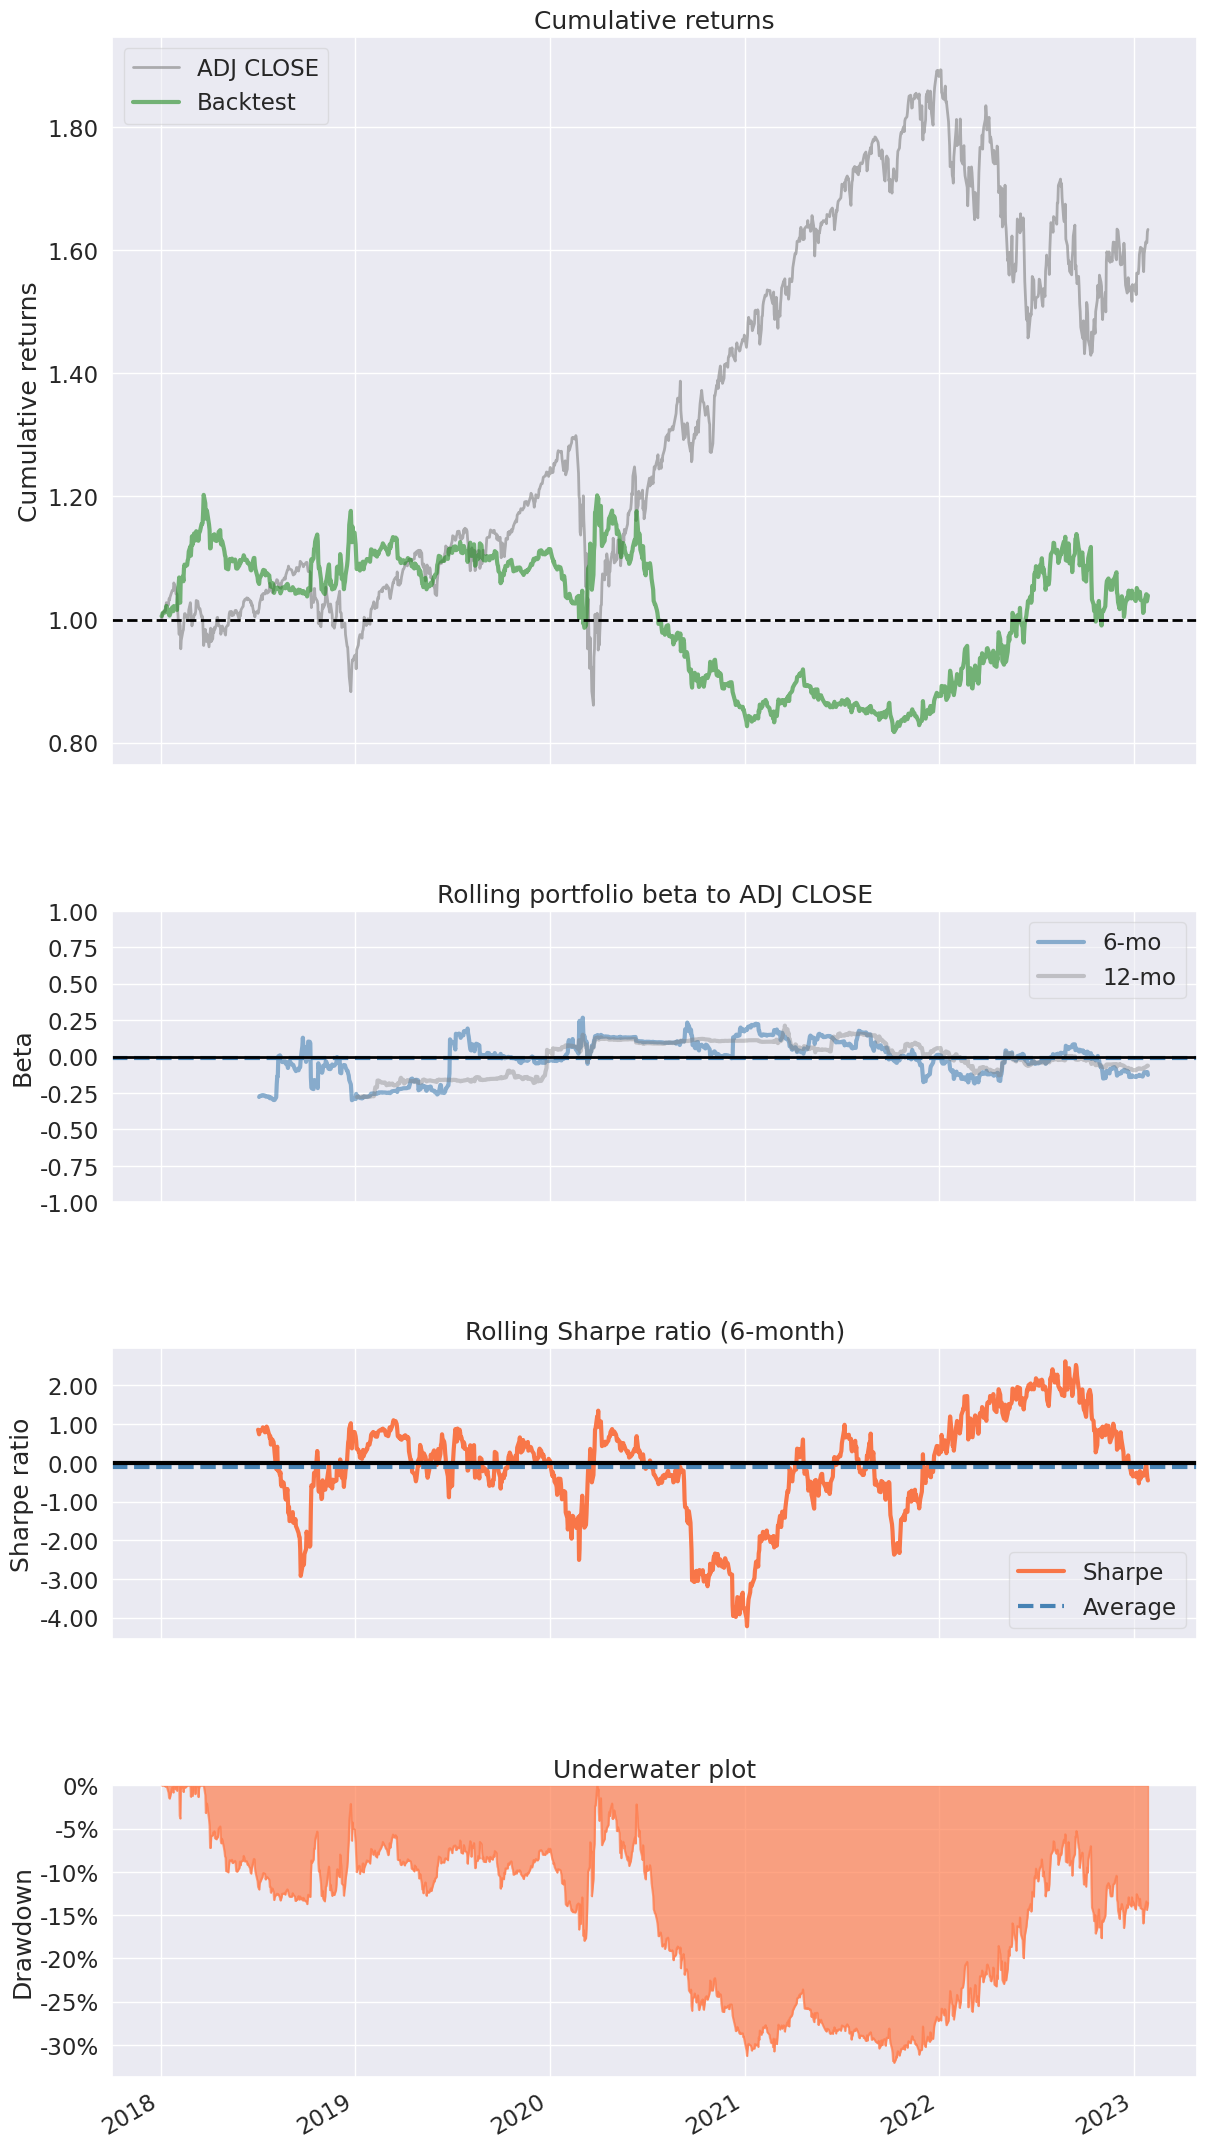

In [21]:
# Create benchmark daily returns for tearsheet analysis
spy_returns = test_signals['ADJ CLOSE'].pct_change()
benchmark=spy_returns

returns = test_signals['daily_backtested_returns']

# Create tearsheet
pyf.tears.create_simple_tear_sheet(returns, benchmark_rets=benchmark)